In [6]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf



PIL.JpegImagePlugin.JpegImageFile

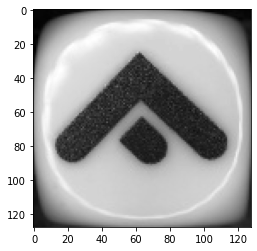

In [7]:
img = Image.open("../assets/train_set/08/16_09_21_08_020.png")

plt.imshow(img, cmap="gray")
type(img)

In [8]:
img = np.array(img)

numpy.ndarray

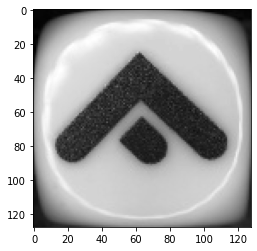

In [9]:
plt.imshow(img, cmap="gray")
type(img)

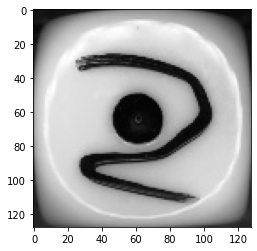

In [10]:
"../assets/train_set/08/16_09_21_08_020.png"
img = Image.open("../assets/train_set/ano/17_11_21_anomalies_000.png")
plt.imshow(img, cmap="gray")

In [11]:
def create_dataset():
    directory = "../assets/train_set/"
    data= []
    label= []
    for i in range(0, 10):
        for filename in os.listdir(directory+"0"+str(i)):
            if filename.endswith(".png"):
                img = Image.open(directory+"0"+str(i)+"/"+filename)
                data.append(np.array(img))
                label.append(i+1)
                
    print(len(data))
    return data, label

In [12]:
data, labels= create_dataset() 

6151


In [13]:
data[5][10]

array([ 20,  19,  18,  20,  23,  33,  65,  83,  95, 106, 116, 123, 131,
       137, 144, 151, 157, 164, 171, 177, 183, 187, 190, 194, 197, 199,
       204, 209, 212, 213, 214, 216, 229, 238, 247, 252, 254, 255, 253,
       250, 238, 232, 225, 221, 218, 217, 217, 217, 216, 216, 216, 216,
       216, 216, 215, 214, 216, 216, 217, 217, 216, 216, 216, 216, 215,
       215, 215, 215, 215, 215, 215, 215, 214, 214, 214, 214, 214, 214,
       214, 214, 214, 214, 213, 213, 213, 213, 213, 213, 213, 213, 213,
       211, 212, 216, 223, 230, 226, 224, 217, 208, 205, 204, 200, 196,
       194, 192, 189, 186, 181, 177, 173, 169, 165, 160, 156, 153, 148,
       144, 139, 134, 129, 124, 116, 109,  99,  89,  80,  48], dtype=uint8)

In [14]:
data = np.array(data)
data.shape

(6151, 128, 128)

In [15]:
preprocessed_data = data/255
labels= np.array(labels).reshape(-1,1)

In [16]:
print("Drawings shape before : ", preprocessed_data.shape)
preprocessed_data = np.expand_dims(preprocessed_data, axis=3)
print("Drawings shape after : ", preprocessed_data.shape)
print("Label shape : ", labels.shape)

Drawings shape before :  (6151, 128, 128)
Drawings shape after :  (6151, 128, 128, 1)
Label shape :  (6151, 1)


In [17]:
from sklearn.model_selection import train_test_split

# split data in train/val/test set
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    preprocessed_data, 
    labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_val_data, 
    train_val_labels,
    test_size=0.3, 
    random_state=42, 
    shuffle=True
)

In [18]:
inputs = tf.keras.Input(shape=(128, 128, 1), name='input_layer')


In [19]:
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

In [20]:
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

In [21]:
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)


In [22]:
def SSIMLoss(y_true, y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [23]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

C:\Users\User\anaconda3\envs\computer_vision\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 128, 128, 32)     128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 64, 64, 64)       256       
 tion)                                                       

In [25]:
dot_img_file = '../assets/autoencoder.png'
tf.keras.utils.plot_model(autoencoder, to_file=dot_img_file, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [26]:
#!rm -rf ./logs/


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [27]:
from keras.callbacks import TensorBoard


In [28]:
hist=autoencoder.fit(train_val_data, train_val_data,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data), callbacks=[TensorBoard(log_dir='../assets/')])
                

Epoch 1/2
39/39 [==============================] - 817s 21s/step - loss: 0.3821 - val_loss: 0.4682
Epoch 2/2
39/39 [==============================] - 855s 22s/step - loss: 0.1122 - val_loss: 0.4432


In [1]:
import pickle

with open('autoencoder_pkl', 'wb') as files:
    pickle.dump(autoencoder, files)

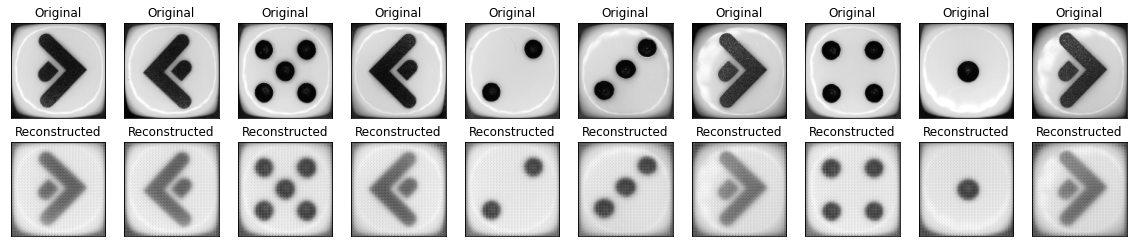

In [30]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [31]:
def create_dataset_ano():
    directory = "../assets/train_set/ano"
    data= []
    label= []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img = Image.open(directory+"/"+filename)
            data.append(np.array(img))
                
    print(len(data))
    return data

In [32]:
anomalies = create_dataset_ano()


56


In [33]:
anomalies = np.array(anomalies)

In [34]:
anomalies.shape


(56, 128, 128)

In [35]:
anomalies = np.expand_dims(anomalies,axis=3)

In [36]:
anomalies.shape

(56, 128, 128, 1)

In [ ]:
print("hello")

In [44]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i+10].reshape(128, 128))
    plt.gray()
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i+10], test_data[i+10])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a))

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i+10].reshape(128, 128))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_imgs[i+10], test_data[i+10])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a))
plt.tight_layout()
plt.show()
plt.savefig("../assets/ssim_loss2")

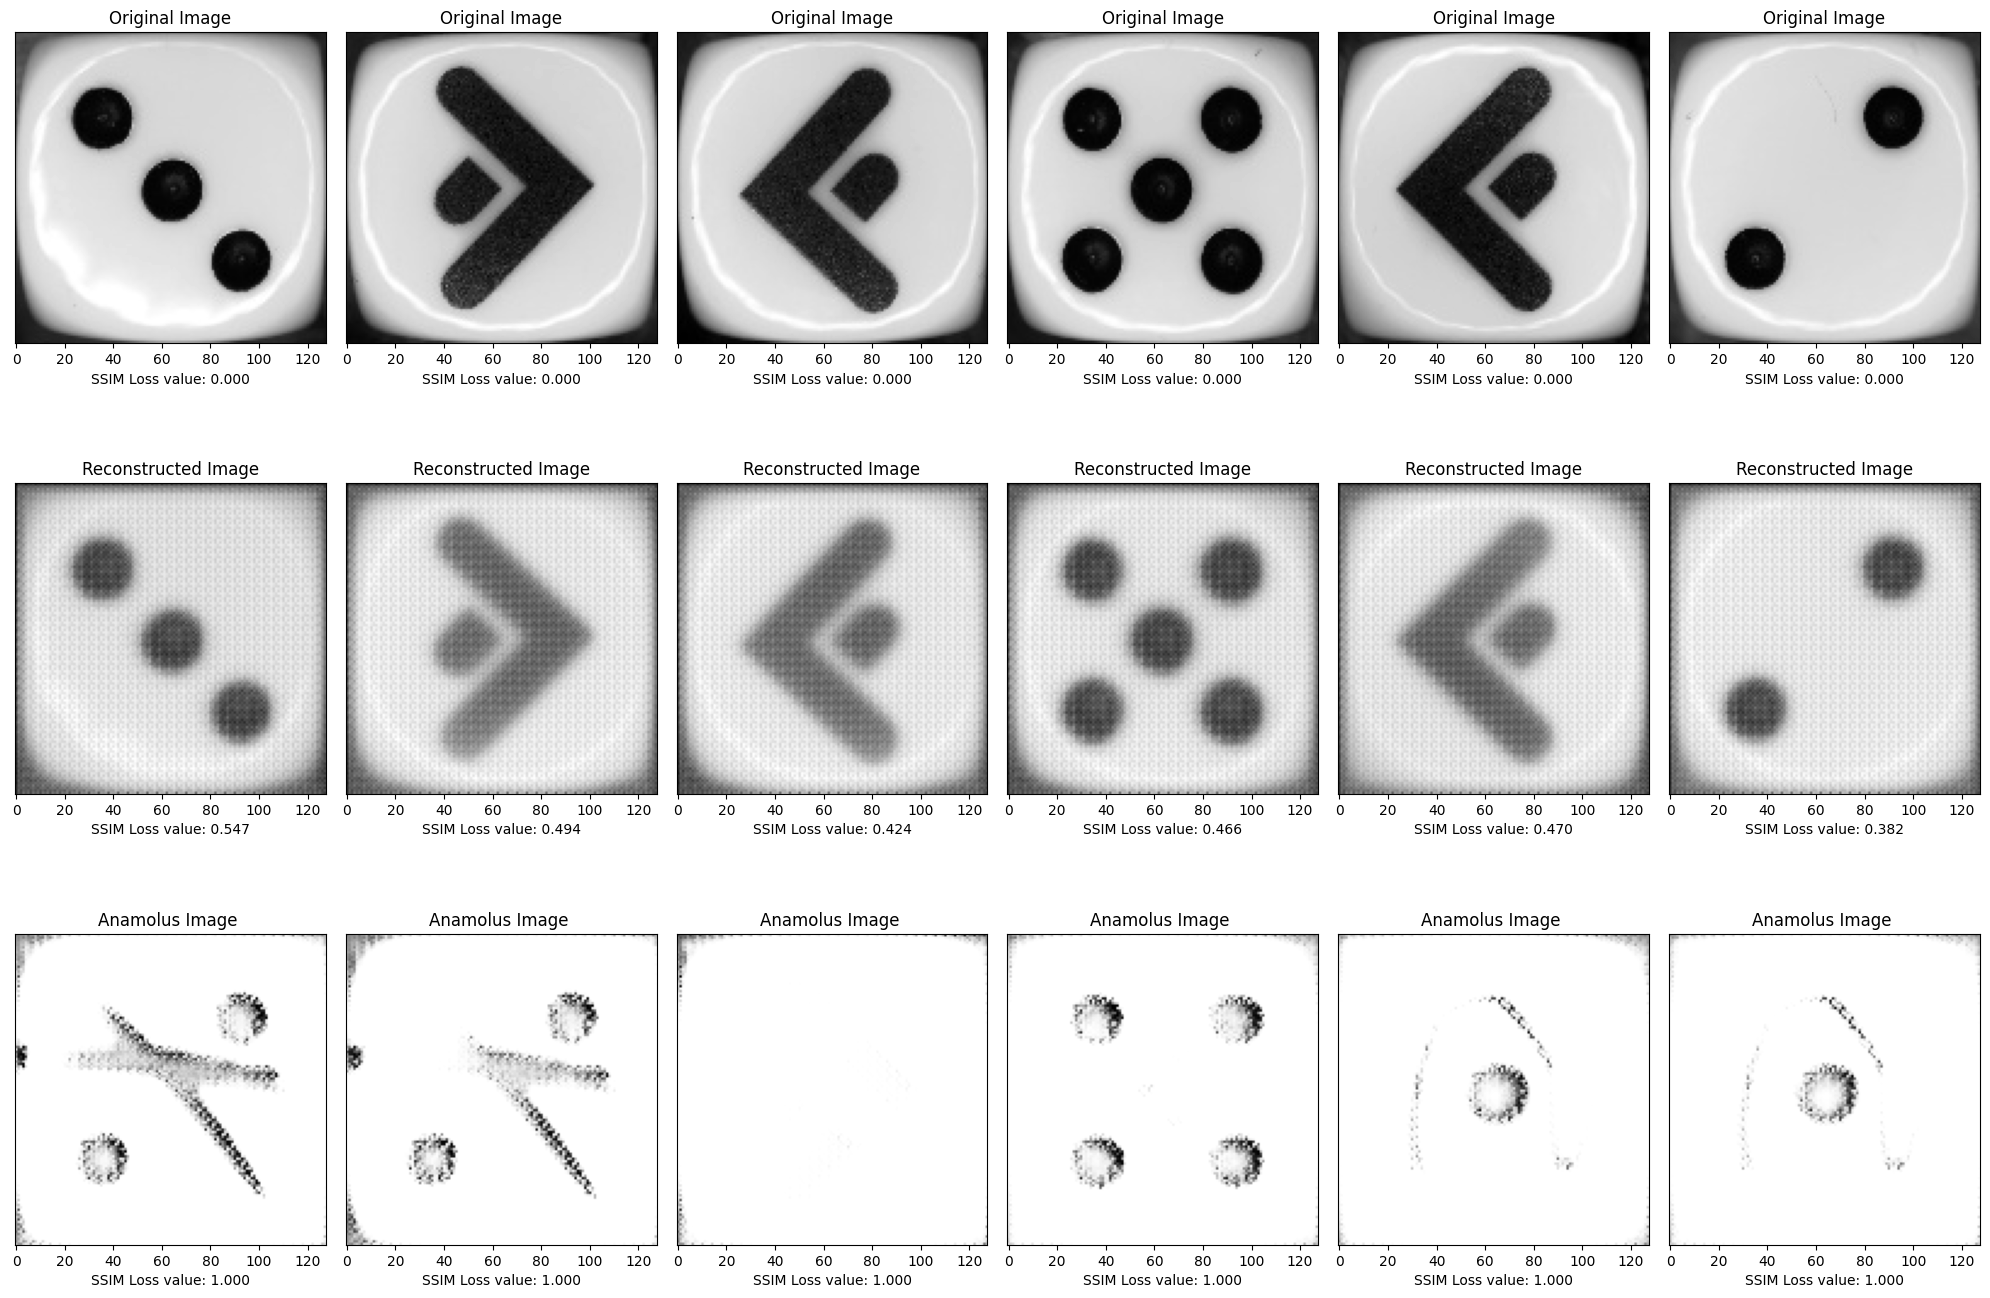

In [39]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display
decoded_imgs= autoencoder.predict(test_data)
decoded_mnistimgs= autoencoder.predict(anomalies)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i+10], test_data[i+10])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i+10], test_data[i+10])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i+10].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_mnistimgs[i+10], anomalies[i+10])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()

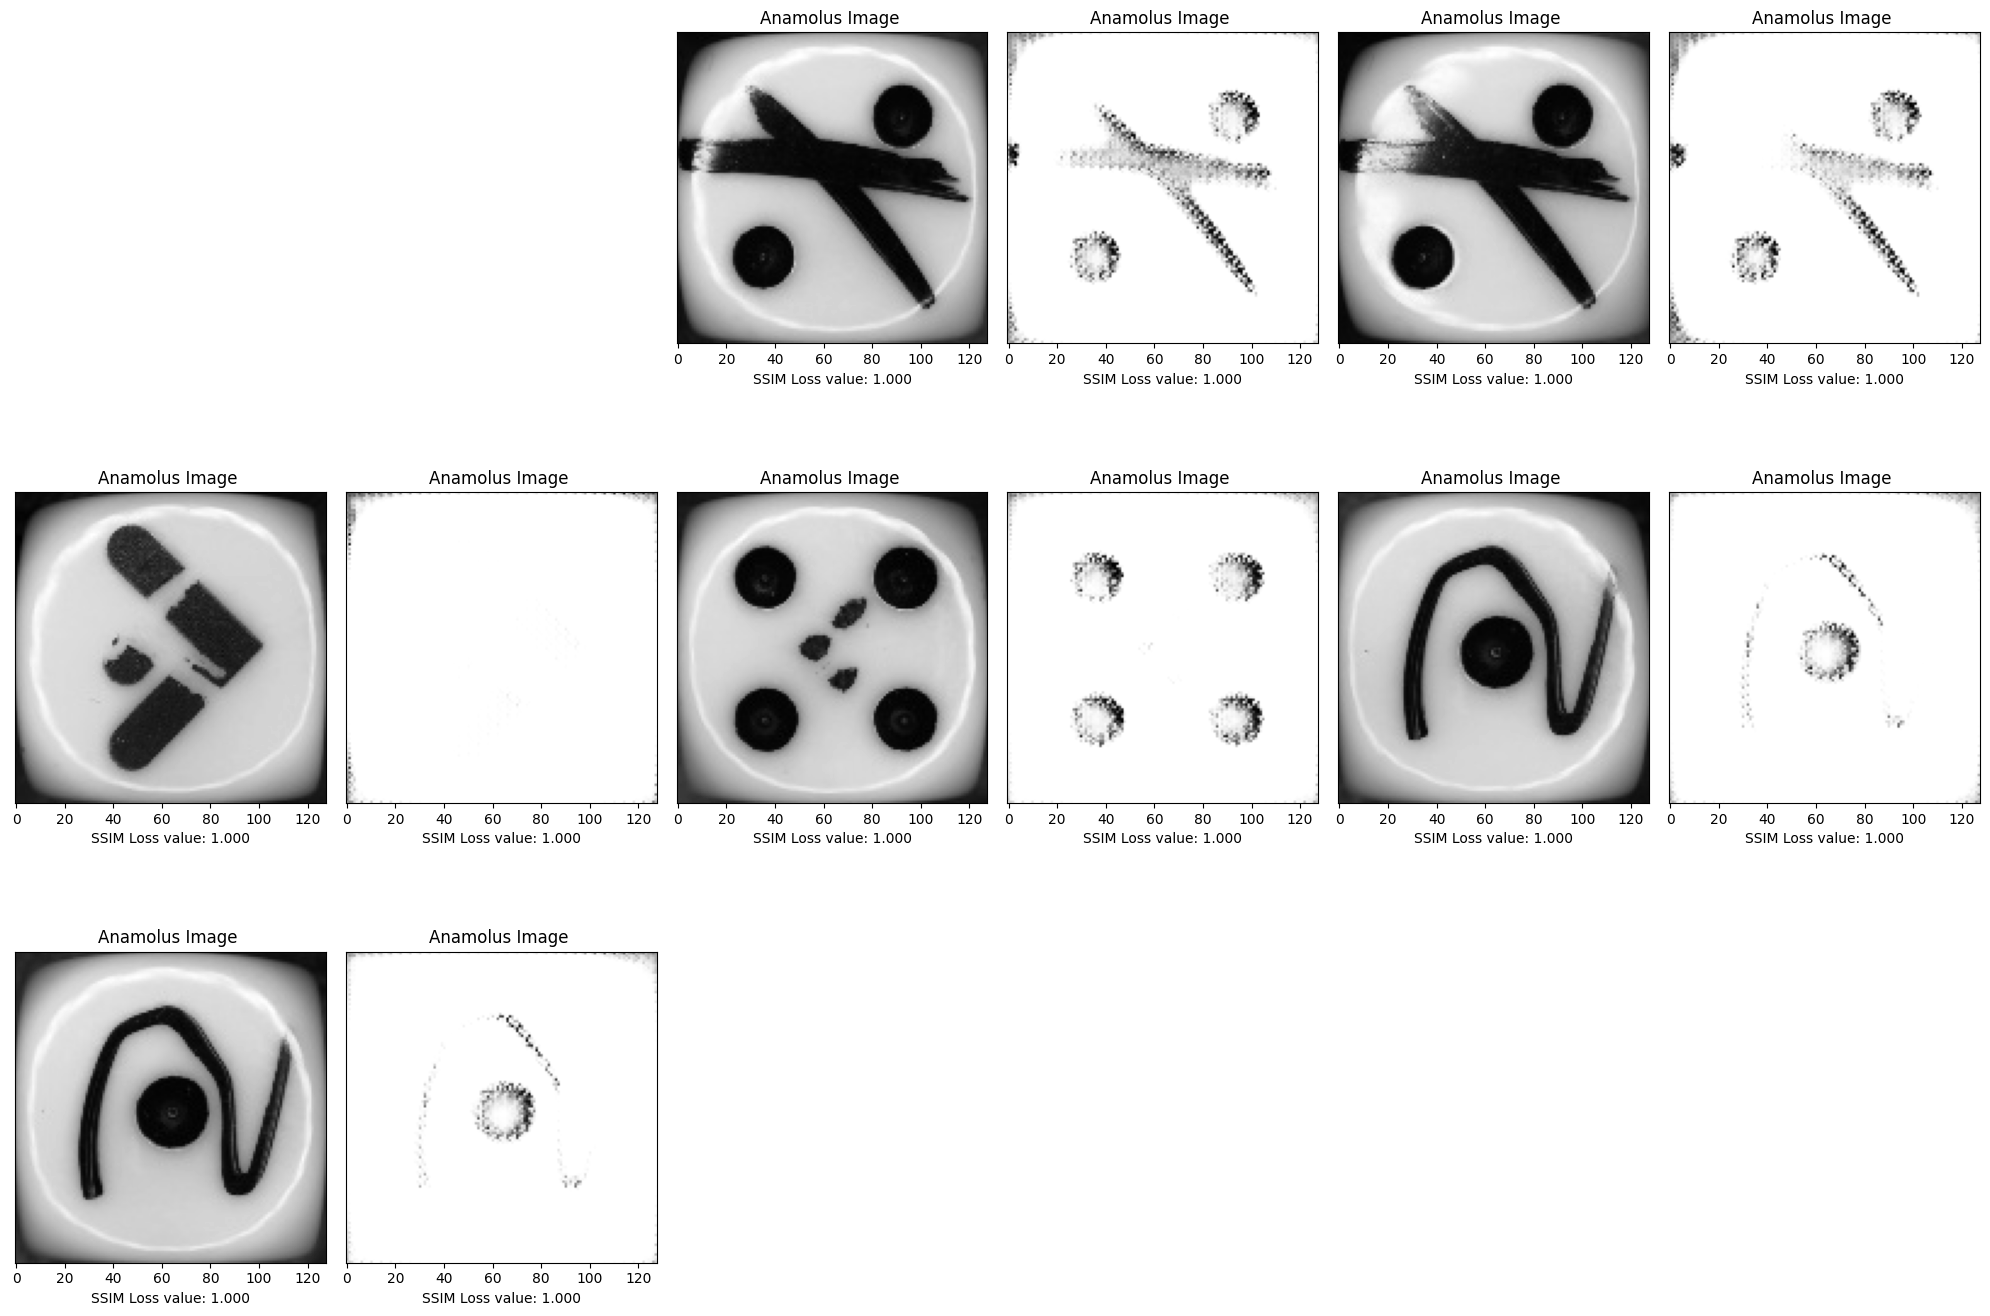

In [41]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display
decoded_imgs= autoencoder.predict(test_data)
decoded_mnistimgs= autoencoder.predict(anomalies)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training

    ax = plt.subplot(3, n, plt_a + 2)
    plt.imshow(anomalies[i+10].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(anomalies[i+10], preprocessed_data[i+10])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2)
    plt.imshow(decoded_mnistimgs[i+10].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_mnistimgs[i+10], anomalies[i+10])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()